In [2]:
from utils import dataloader
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from importlib import reload  

import matplotlib.pyplot as plt

import numpy as np

import torch as th
import torch.nn as nn
import os
from datetime import datetime
import matplotlib as mpl
import torch.optim as optim
import pytorch_ssim

import torch.nn.functional as F
import torchvision.models as models
from torch.autograd import Variable
import torchvision.transforms as transforms
import matplotlib.patches as patches

In /Users/diegocalanzone/anaconda3/envs/tfdeeplearning/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/diegocalanzone/anaconda3/envs/tfdeeplearning/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/diegocalanzone/anaconda3/envs/tfdeeplearning/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
dataloader = reload(dataloader)

plotsize = 15
img_size = 256

partitions = dataloader.DataPartitions(
    past_frames=4,
    future_frames=1,
    root="../datasets/arda/mini/",
    partial=0.01
)

dataset = dataloader.DataGenerator(
    root="../datasets/arda/mini/",
    dataset_partitions=partitions.get_partitions(),
    past_frames=partitions.past_frames, 
    future_frames=partitions.future_frames,
    input_dim=(partitions.past_frames, img_size, img_size, 4),
    output_dim=(partitions.future_frames, img_size, img_size, 3),
    batch_size=4,
    buffer_size=1e3,
    buffer_memory=100,
    downsampling=False,
    dynamicity = 0
)

In [3]:
X, Y, extra_batch = dataset.get_data()

X[X > 10e5] = 0 
Y[Y > 10e5] = 0


[x] 1 areas found
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
[100%] 35 valid sequences loaded


Text(0.5, 1.05, 'VVY')

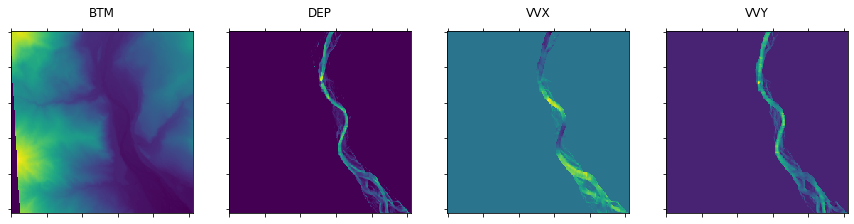

In [18]:
fig, axs = plt.subplots(1, 4, figsize=(plotsize,plotsize))

for ax in axs:
    ax.set_yticklabels([])
    ax.set_xticklabels([])

# dep, vvx, vvy, btm

axs[0].matshow(X[0,0,0,:,:,3])
axs[0].set_title("BTM")

axs[1].matshow(X[0,0,0,:,:,0])
axs[1].set_title("DEP")

axs[2].matshow(X[0,0,0,:,:,1])
axs[2].set_title("VVX")

axs[3].matshow(X[0,0,0,:,:,2])
axs[3].set_title("VVY")


In [5]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

X, Y = unison_shuffled_copies(X, Y)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [7]:
X_train.shape


(6, 4, 4, 256, 256, 4)

In [8]:
print("DEP min: {}\nVEL min: {}\nBTM min: {}".format(
    np.min(X_train[:, :, :, :, :, 0]),
    np.min(X_train[:, :, :, :, :, 1]),
    np.min(X_train[:, :, :, :, :, 2])
))

print("DEP max: {}\nVEL max: {}\nBTM max: {}".format(
    np.max(X_train[:, :, :, :, :, 0]),
    np.max(X_train[:, :, :, :, :, 1]),
    np.max(X_train[:, :, :, :, :, 2])
))

DEP min: 0.0
VEL min: -3.08131
BTM min: -0.691004
DEP max: 4.41437
VEL max: 4.87484
BTM max: 6.92959


### Model

In [9]:
import torch.nn.functional as F
from functools import partial

In [10]:
def xavier_weights(m):
    if isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose3d):
        th.nn.init.xavier_uniform(m.weight.data)

def sqrt_weights(m):
    # https://stackoverflow.com/questions/49433936/how-to-initialize-weights-in-pytorch
    if isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose3d):
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)

In [11]:
if th.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
device = th.device(dev)
print(device)

cpu


In [19]:
from models.ae import ConvLSTMCell

from models.ae import seq2seq_ConvLSTM
seq2seq_ConvLSTM = reload(seq2seq_ConvLSTM)

net = seq2seq_ConvLSTM.EncoderDecoderConvLSTM(nf=4, in_chan=4, out_chan=3).to(device) # False: many to one

test_in = th.Tensor(X[0]).unsqueeze(0).to(device)
test_in = test_in.permute(0, 1, 2, 5, 3, 4)
print(net(test_in[0], 1).shape)

torch.Size([4, 3, 1, 256, 256])


In [13]:
X_train = th.Tensor(X_train).to(device)
y_train = th.Tensor(y_train).to(device)

In [14]:
# b, s, t, h, w, c -> b, s, t, c, h, w
X_train = X_train.permute(0, 1, 2, 5, 3, 4)
y_train = y_train.permute(0, 1, 2, 5, 3, 4)

In [15]:
X_test = th.Tensor(X_test).to(device)
y_test = th.Tensor(y_test).to(device)

In [16]:
# b, s, t, h, w, c -> b, s, t, c, h, w
X_test = X_test.permute(0, 1, 2, 5, 3, 4)
y_test = y_test.permute(0, 1, 2, 5, 3, 4)

torch.Size([6, 4, 4, 4, 256, 256])


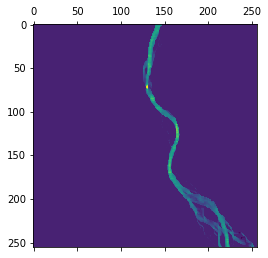

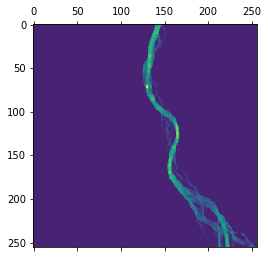

In [17]:
plt.matshow(X_train[2,2,0,2,:,:].cpu().numpy())
plt.matshow(y_train[2,2,0,2,:,:].cpu().numpy())
print(X_train.shape)

<ipython-input-17-37b3e947f1d3>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, sequence.shape[0], figsize=(plotsize,plotsize))


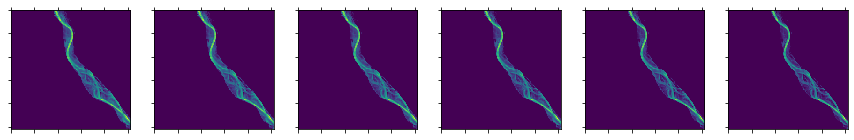

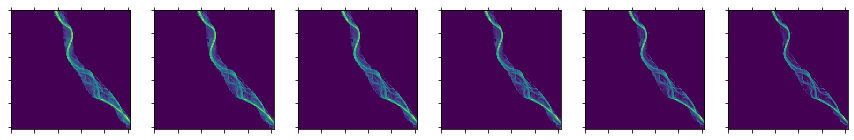

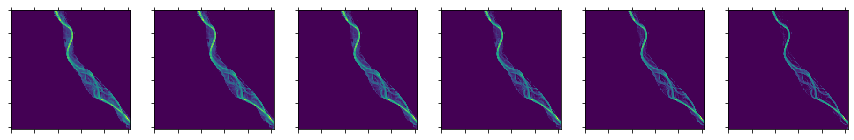

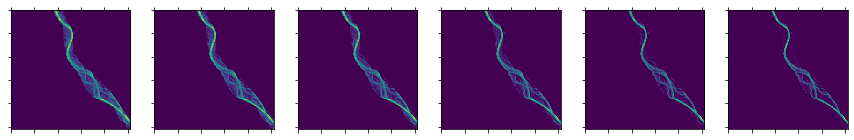

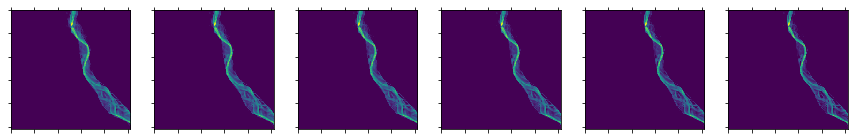

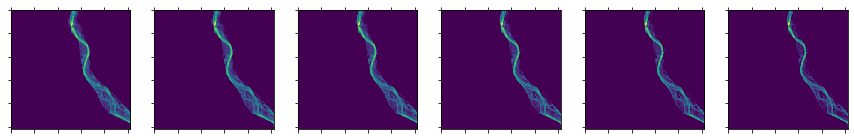

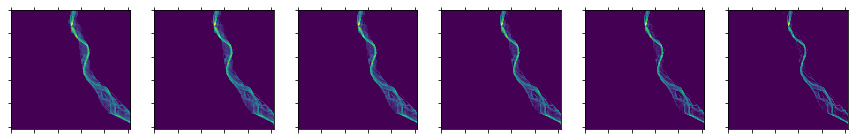

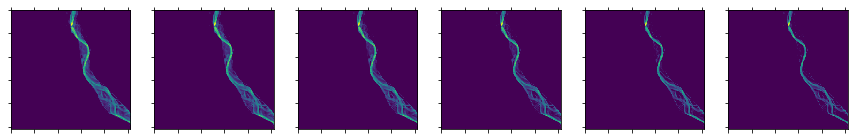

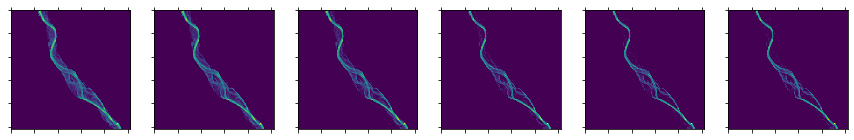

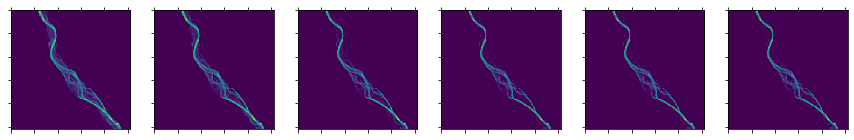

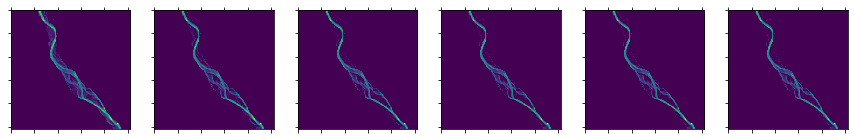

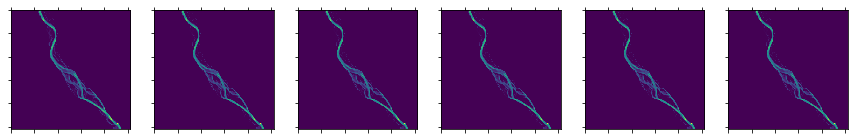

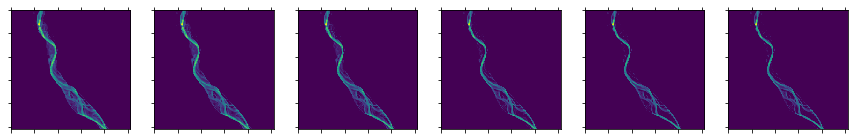

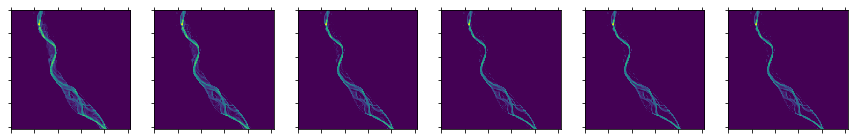

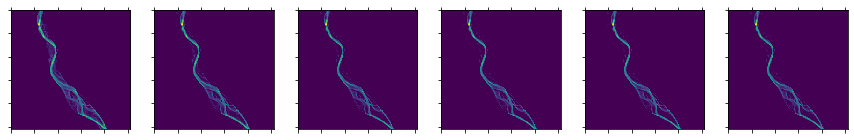

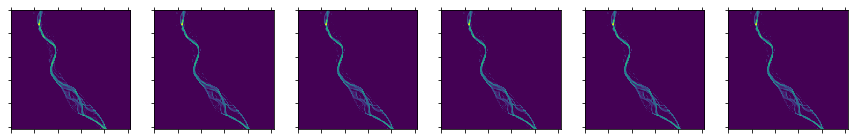

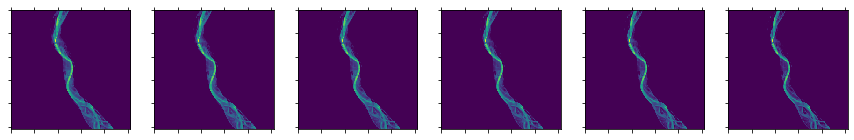

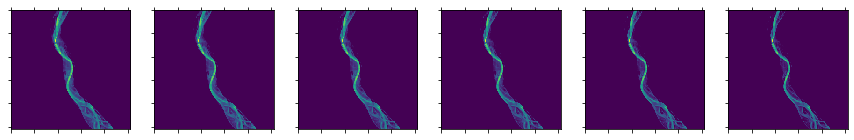

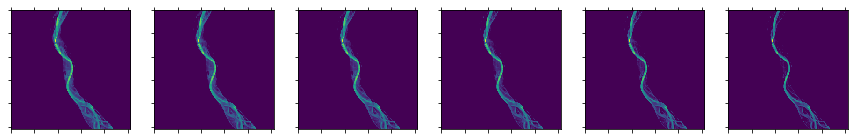

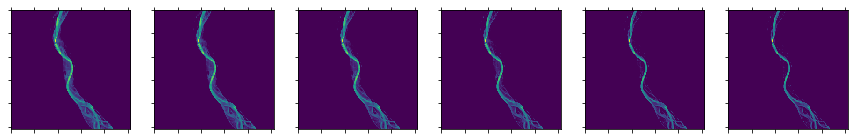

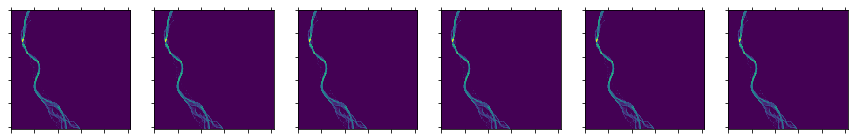

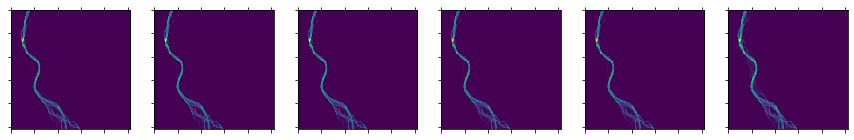

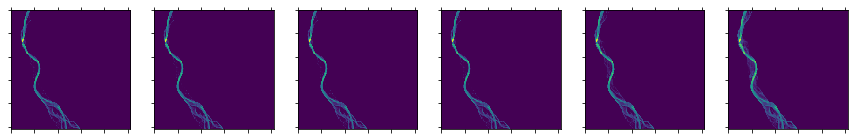

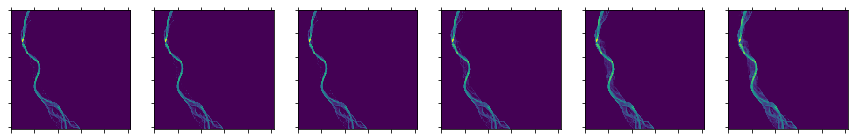

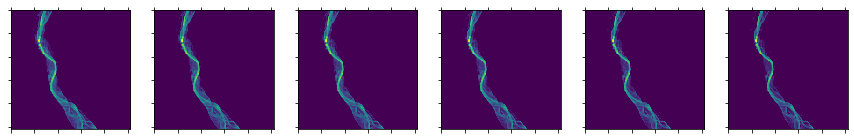

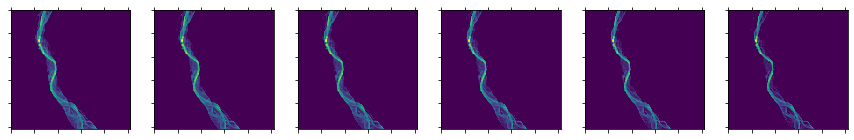

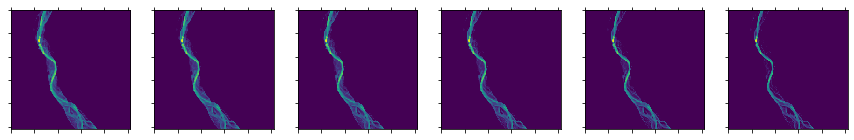

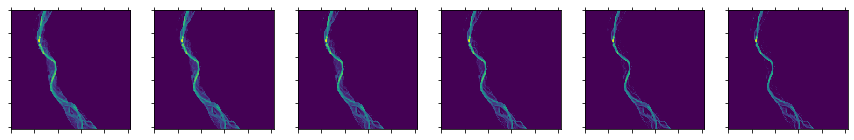

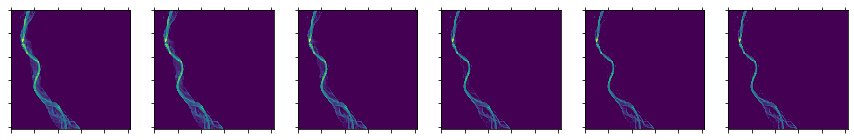

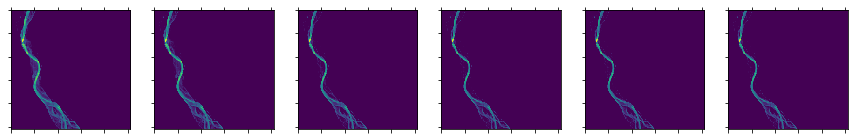

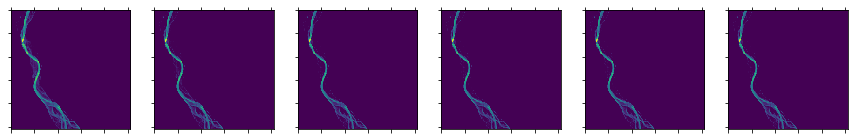

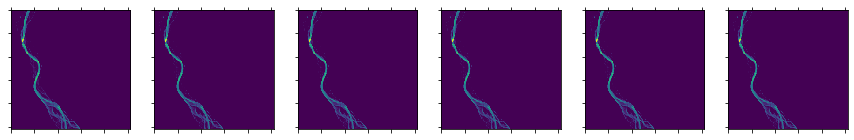

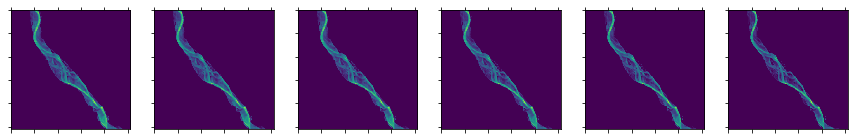

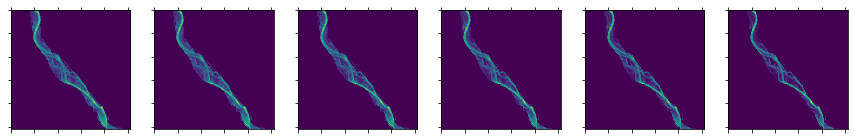

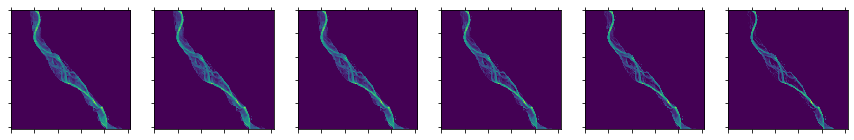

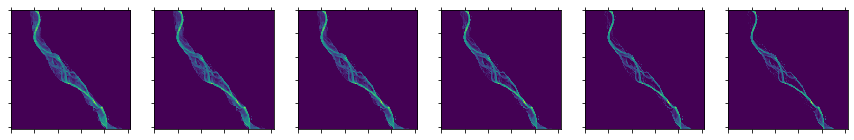

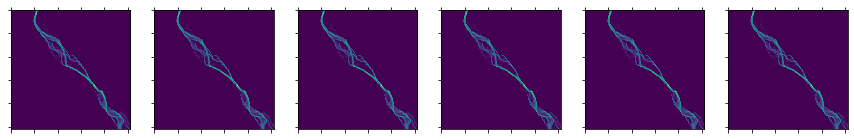

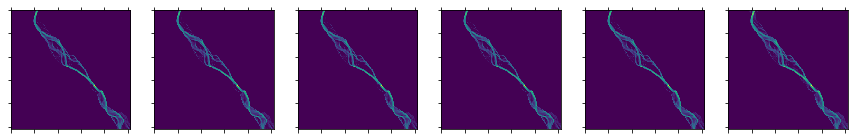

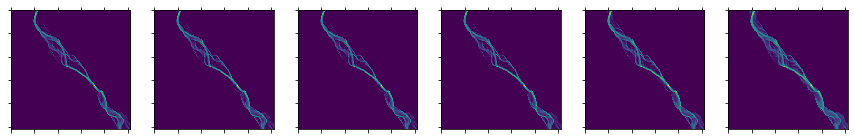

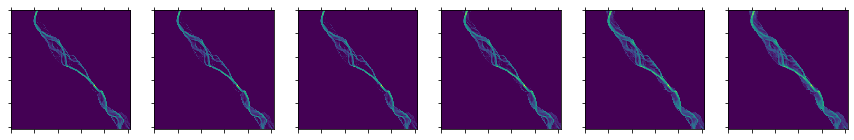

In [17]:
'''
# Valid sequences
for i, batch in enumerate(X_train):

    if i == 10: break
    for j, sequence in enumerate(batch):

        # first three channels (dep, vvx, vvy): x/y aligned
        #sequence = np.concatenate((sequence[:,:3,:,:], y_train[i,j,:,0,:,:].unsqueeze(0)), axis=0)

        fig, axs = plt.subplots(1, sequence.shape[0], figsize=(plotsize,plotsize))

        for ax in axs:
            ax.set_yticklabels([])
            ax.set_xticklabels([])

        for k,frame in enumerate(sequence):   # x frames
            axs[k].matshow(frame[0].cpu().numpy())
'''

In [20]:
ssim = pytorch_ssim.SSIM()
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(net.parameters(), lr=1e-4)

In [21]:
losses = []
errors = []
test_errors = []

def mass_conservation_loss(output, target):

    # output: b, h, w
    diff = 0
    for i,datapoint in enumerate(output):
        target_sum = th.sum(
                th.abs(target[i])
            )
        pred_sum = th.sum(
                th.abs(output[i])
            )

        diff += th.abs(target_sum - pred_sum)/target_sum

    return diff

epoch 0 -- avg loss: 5040.456994398585
[!] Comparison matrices printed


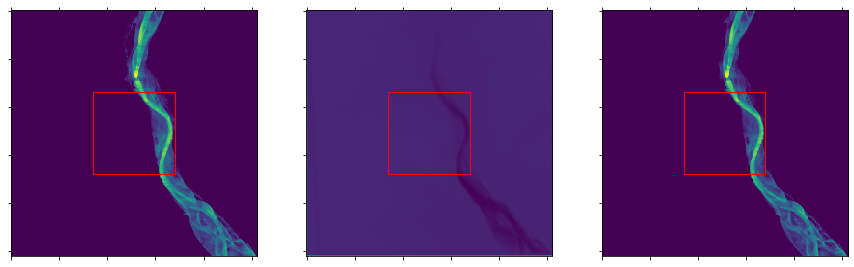

epoch 1 -- avg loss: 9055.168200476695
[!] Comparison matrices printed


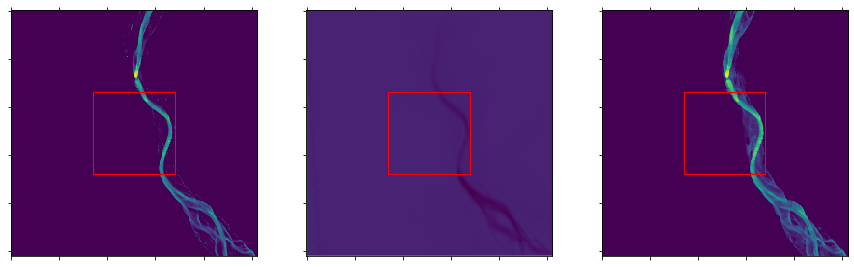

epoch 2 -- avg loss: 12328.121033653846
[!] Comparison matrices printed


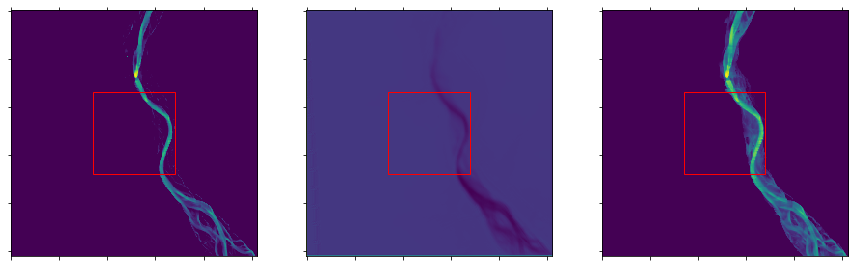

epoch 3 -- avg loss: 15047.344657790492
[!] Comparison matrices printed


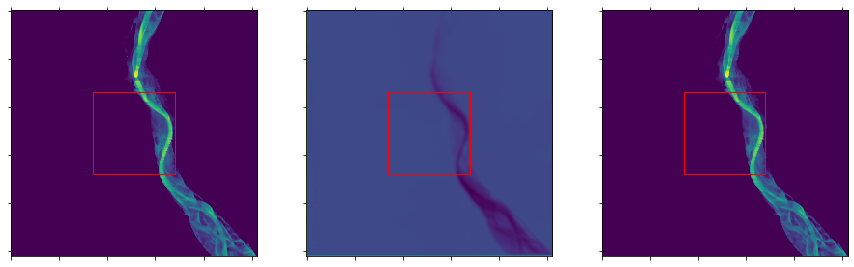

epoch 4 -- avg loss: 17342.336546266233
[!] Comparison matrices printed


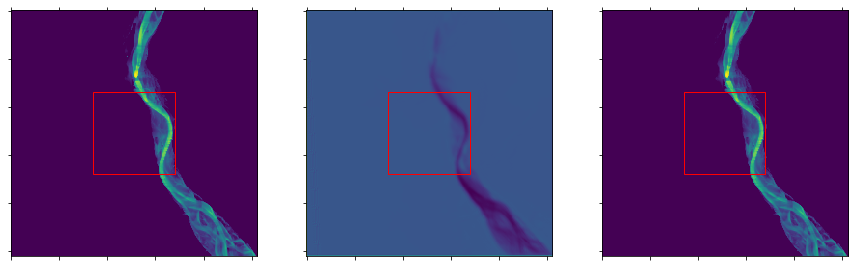

epoch 5 -- avg loss: 19305.0675592997
[!] Comparison matrices printed


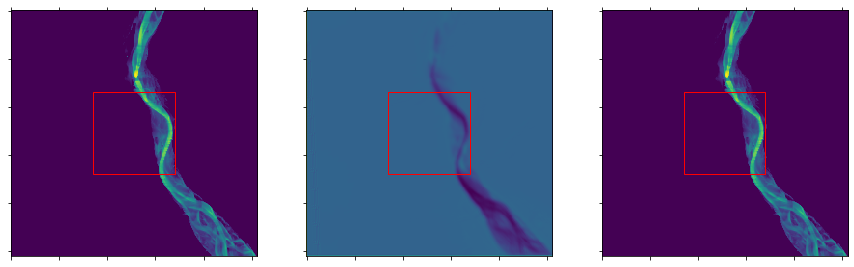

epoch 6 -- avg loss: 21002.737557057586
[!] Comparison matrices printed


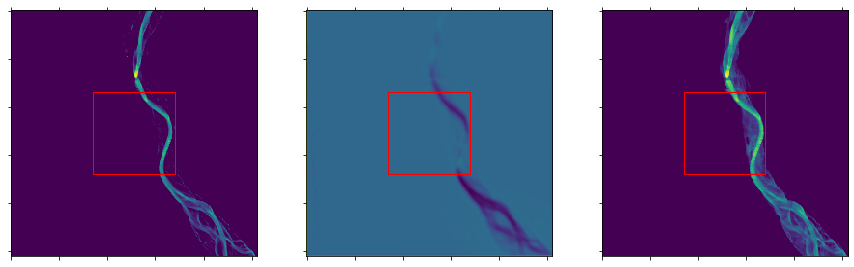

epoch 7 -- avg loss: 22485.583182565788
[!] Comparison matrices printed


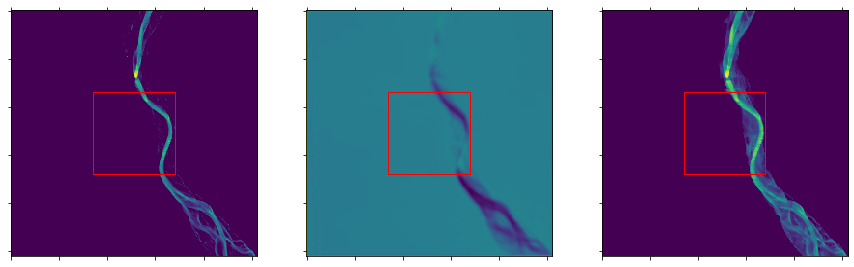

epoch 8 -- avg loss: 23791.842763768564
[!] Comparison matrices printed


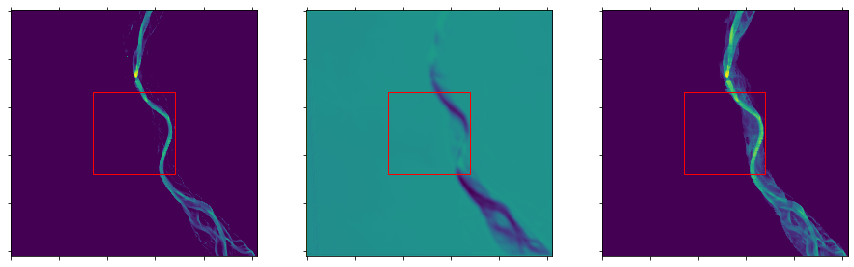

epoch 9 -- avg loss: 24951.204694801403
[!] Comparison matrices printed


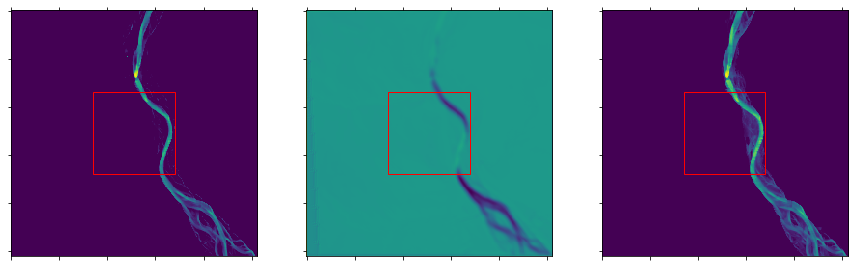

epoch 10 -- avg loss: 25986.99073561947
[!] Comparison matrices printed


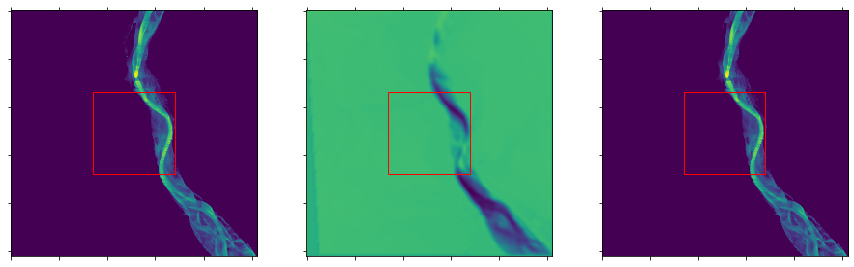

epoch 11 -- avg loss: 26917.845588235294
[!] Comparison matrices printed


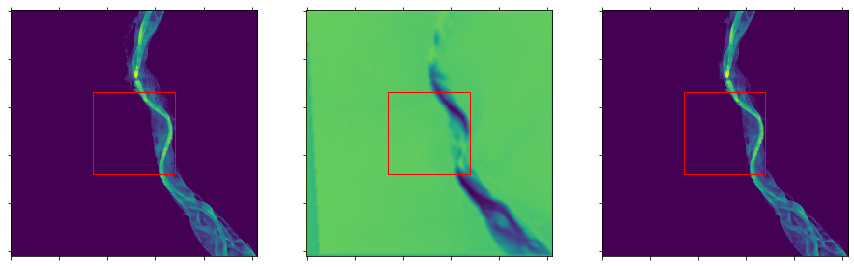

epoch 12 -- avg loss: 27758.7813125
[!] Comparison matrices printed


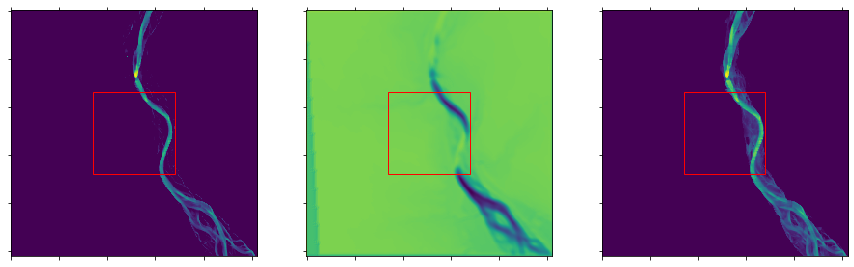

epoch 13 -- avg loss: 28522.081867247136
[!] Comparison matrices printed


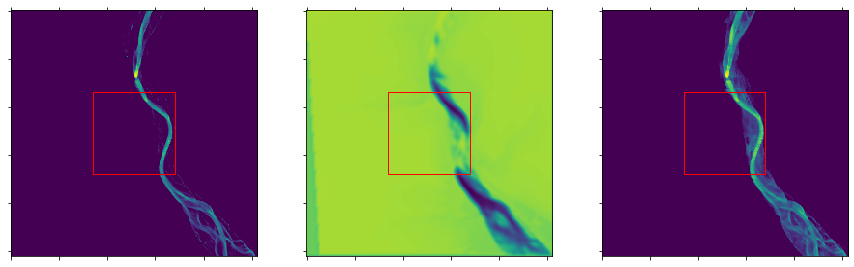

epoch 14 -- avg loss: 29217.823420392335
[!] Comparison matrices printed


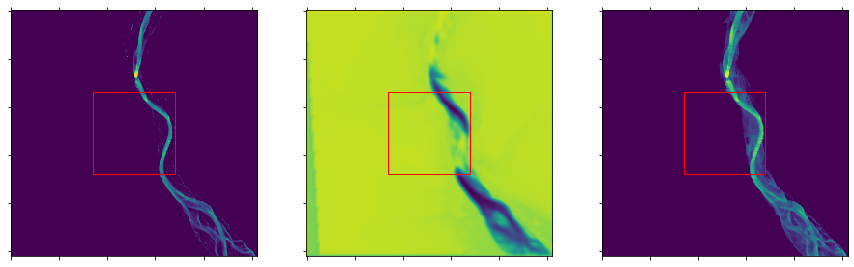

epoch 15 -- avg loss: 29854.393056162586
[!] Comparison matrices printed


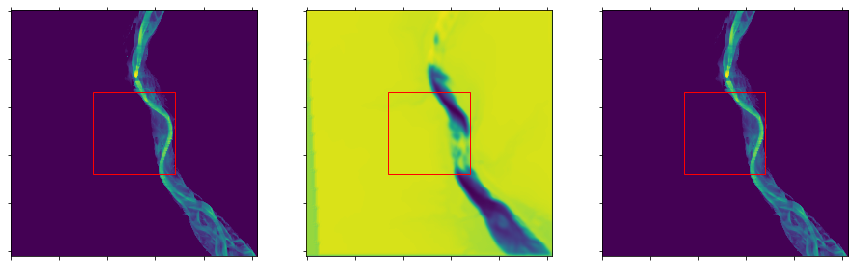

epoch 16 -- avg loss: 30438.79227401426
[!] Comparison matrices printed


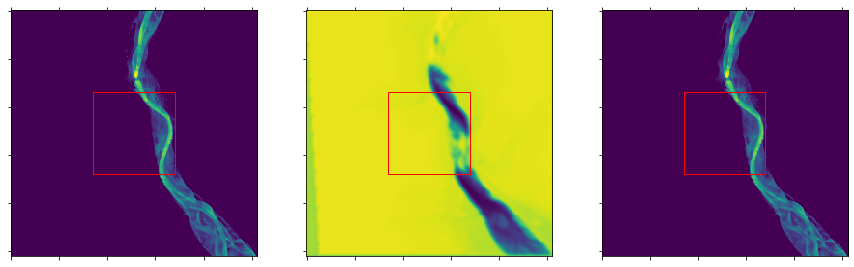

epoch 17 -- avg loss: 30976.919606854837
[!] Comparison matrices printed


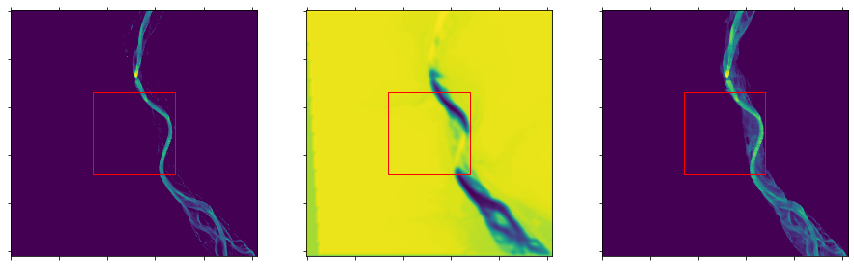

In [37]:
epochs = 200

for epoch in range(epochs):  # loop over the dataset multiple times

    for i, batch in enumerate(X_train):

        optimizer.zero_grad()

        # ---- Predicting
        #print(X_train.shape)
        #print(batch.shape)
        outputs = net(batch,1) # 0 for layer index, 0 for h index
        # ---- Batch Loss

        xstart=85
        xend=170
        ystart=85
        yend=170
        
        loss = criterion(outputs[:,:,0,ystart:yend,xstart:xend], y_train[i,:,0,:,ystart:yend,xstart:xend])
        #loss += mass_conservation_loss(outputs[:,0,:,:], y_train[i,:,0,0,:,:])
        
        '''
        ssim_loss = None
        for x in range(outputs.shape[1]):
            img1 = Variable( outputs[x,0,:,:].unsqueeze(0),  requires_grad=False)
            img2 = Variable( y_train[i,x,0,0,:,:].unsqueeze(0).unsqueeze(0), requires_grad = True)

            if ssim_loss is None: ssim_loss = 1/ssim(img1, img2)
            else: ssim_loss += 1/ssim(img1, img2)

            #loss += mass_conservation_loss(img1, img2)

            #print("ssim loss: \t{}".format(-criterion(img1, img2)))
            #print("mass conservation loss:\t{}".format(mass_conservation_loss(img1, img2)))

        loss = criterion(outputs[:,0,:,:], y_train[i,:,0,0,:,:]) + ssim_loss
        '''

        loss.backward()
        optimizer.step()

        # print statistics
        losses.append(loss.item())

        #print("batch {} - loss {}".format(i, loss.item()))

    if epoch % 1 == 0:

        print("epoch {} -- avg loss: {}".format(epoch, np.mean(losses)))

        k = np.random.randint(len(X_test))

        outputs = net(X_test[k],1) # 0 for layer index, 0 for h index

        #np.savetxt('output.txt',outputs[0,0,:,:].cpu().detach().numpy(),fmt='%.2f')
        #np.savetxt('real.txt',y_train[k,0,0,0].cpu().detach().numpy(),fmt='%.2f')

        #------------------------------
        fig, axs = plt.subplots(1, 3, figsize=(plotsize,plotsize))

        for ax in axs:
            ax.set_yticklabels([])
            ax.set_xticklabels([])

        # pick random datapoint from batch
        x = np.random.randint(X_test[k].shape[0])


        for i,frame in enumerate(X_train[k,x,-1:]):
            axs[i].matshow(frame[0].cpu().detach().numpy())
            # Add the patch to the Axes

            rect = patches.Rectangle((85, 85), 85, 85, linewidth=1, edgecolor='r', facecolor='none')
            axs[i].add_patch(rect)

        #predicted = th.mm(outputs[x][0], X_train[k,x,-1,1])
        axs[i+1].matshow(outputs[x][0][0].cpu().detach().numpy())

        rect = patches.Rectangle((85, 85), 85, 85, linewidth=1, edgecolor='r', facecolor='none')
        axs[i+1].add_patch(rect)
        
        axs[i+2].matshow(y_test[k,x][0][0].cpu().detach().numpy())

        rect = patches.Rectangle((85, 85), 85, 85, linewidth=1, edgecolor='r', facecolor='none')
        axs[i+2].add_patch(rect)
        #axs[i+2].matshow(outputs[x][1].cpu().detach().numpy())
        #axs[i+3].matshow(outputs[x][2].cpu().detach().numpy())

        plt.show()
        #------------------------------

        #if epoch % 10 == 0:
        #    print('[%d, %5d] loss: %.3f' %
        #          (epoch + 1, i + 1, running_loss / 2000))
        #    running_loss = 0.0

print('Finished Training')

In [1]:
th.save(net.state_dict(), "15_8_21.weights")
'''
num_run = len(os.listdir("runs/")) + 1
now = datetime.now()
foldername = "train_{}_{}".format(num_run, now.strftime("%d_%m_%Y_%H_%M_%S"))
os.mkdir("runs/" + foldername)

weights_path = "runs/" + foldername + "/model.weights"
th.save(net.state_dict(), weights_path)
'''

NameError: name 'th' is not defined

In [ ]:
mpl.rcParams['text.color'] = 'k'

plt.title("loss")
plt.plot(range(len(losses)), losses)
pass

In [ ]:
'''
plt.title("relative error")
plt.plot(range(len(errors)), errors, label="train")
plt.plot(range(len(test_errors)), test_errors, label="test")
plt.legend()
pass
'''

In [ ]:
mpl.rcParams['text.color'] = 'w'
prep = Preprocessing()

In [ ]:
j = np.random.randint(len(y_test))
j = 3
m = 2
k = 4

print("k = {}".format(k))

#k = 5
input = th.unsqueeze(X_test[j, m], 0)
outputs = net(input)

#------------------------------
num_predicted_frames = outputs[0, 0].shape[0] # per allineare frames passati e futuri
fig, axs = plt.subplots(1, num_predicted_frames, figsize=(plotsize,plotsize))

for ax in axs:
    ax.set_yticklabels([])
    ax.set_xticklabels([])

for i,frame in enumerate(input[0,0,-num_predicted_frames:]):
    frame = frame.cpu().detach().numpy()
    axs[i].matshow(frame)
    axs[i].set_title('t = {}'.format(i))

print("======== Past frames ========")
plt.show()

print("======== True Future vs Predicted frames ========")

#------------------------------
fig, axs = plt.subplots(1, num_predicted_frames, figsize=(plotsize,plotsize))

for ax in axs:
    ax.set_yticklabels([])
    ax.set_xticklabels([])

for i,frame in enumerate(y_test[j,m,0]):
    axs[i].matshow(frame.cpu().detach().numpy())
    axs[i].set_title('t = {}'.format(i+num_predicted_frames))

plt.show()
#------------------------------
fig, axs = plt.subplots(1, outputs[0,0].shape[0], figsize=(plotsize,plotsize))

for ax in axs:
    ax.set_yticklabels([])
    ax.set_xticklabels([])

for i,frame in enumerate(outputs[0,0]):
    attention_mask = outputs[0,1,i].cpu().detach().numpy()
    y_frame = frame.cpu().detach().numpy()
    y_true = y_test[j,m,0,i].cpu().detach().numpy()

    y_frame = np.dot(y_frame, attention_mask)
    y_true = np.dot(y_true, attention_mask)

    print(y_frame[:5,:5])
    print("#-------------")
    print(y_true[:5,:5])
    print("\n\n")

    ssim = prep.pytorch_ssim(y_true, y_frame).item()
    axs[i].matshow(y_frame)
    axs[i].set_title('ssim = {}'.format(ssim))

plt.show()
#------------------------------

In [ ]:
print("k = {}".format(k))
iterations = 4
#k = 5

input = th.unsqueeze(X_train[k,0], 0)
outputs = net(input)

#------------------------------
print("======== Past frames ========")
num_predicted_frames = outputs[0,0].shape[0] # per allineare frames passati e futuri
fig, axs = plt.subplots(1, num_predicted_frames, figsize=(plotsize,plotsize))

for ax in axs:
    ax.set_yticklabels([])
    ax.set_xticklabels([])

for i,frame in enumerate(input[0,0,-num_predicted_frames:]):
    axs[i].matshow(frame.cpu().detach().numpy())
    axs[i].set_title('t = {}'.format(i))

plt.show()
#------------------------------
print("======== True vs Autoregressive Pred Frames  ========")
fig, axs = plt.subplots(1, num_predicted_frames, figsize=(plotsize,plotsize))

true_means = []

for ax in axs:
    ax.set_yticklabels([])
    ax.set_xticklabels([])

for i,frame in enumerate(y_train[k,0,0]):
    axs[i].matshow(frame.cpu().detach().numpy())
    axs[i].set_title('t = {}'.format(i+num_predicted_frames))
    true_means.append(frame.cpu().detach().numpy().mean())

plt.show()
#------------------------------

#i = np.random.randint(len(X_test))
input = th.unsqueeze(X_train[k][0], 0)

fig, axs = plt.subplots(1, iterations, figsize=(plotsize,plotsize))

for ax in axs:
    ax.set_yticklabels([])
    ax.set_xticklabels([])

predicted_means = []
for x in range(iterations):
    # first predicted frame only
    output = th.unsqueeze(net(input)[:,:,0,:,:],2)
    # next frame = first predicted from output + btm map
    next_frame = output.detach()
    next_frame = th.cat((next_frame, th.unsqueeze(input[:,2:,0,:,:],2)), axis=1)
    # added on top of (input sequence - first frame)
    input = th.cat((next_frame, input[:,:,1:,:]), axis=2)

    axs[x].matshow(output[0,0,0].cpu().detach().numpy())
    axs[x].set_title('t = {}'.format(x+num_predicted_frames))
    predicted_means.append(output[0,0,0].cpu().detach().numpy().mean())
    #print(np.mean(output[0,0,0].cpu().detach().numpy()))

plt.show()

In [ ]:
mpl.rcParams['text.color'] = 'b'

plt.clf()
plt.plot(range(len(true_means)), true_means,  "-b", label="True frames mean")
plt.plot(range(len(true_means)), true_means,  "*")

plt.plot(range(len(predicted_means)), predicted_means,  "-g", label="Predicted frames mean")
plt.plot(range(len(predicted_means)), predicted_means,  "*")
plt.grid()
plt.legend()
pass

In [ ]:
print("{:<20s}{:<20s}{:<20s}{:<20s}{:<20s}".format("", "min", "max", "mean", "std"))
print("{:<20s}{:<20f}{:<20f}{:<20f}{:<20f}".format("prediction", th.min(outputs), th.max(outputs), th.mean(outputs), th.std(outputs)))
print("{:<20s}{:<20f}{:<20f}{:<20f}{:<20f}".format("true", th.min(y_test[0]), th.max(y_test[0]), th.mean(y_test[0]), th.std(y_test[0])))
'''